In [10]:
import sys
sys.path.append("..")

import numpy as np
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
from src.graphgen.synthetic_graph_dataset_PyG import *
from torch_geometric.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch_geometric.nn import GCNConv, GraphConv, global_mean_pool, global_add_pool
from captum.attr import Saliency, IntegratedGradients

In [11]:
dataset = SyntheticGraphDatasetPyG('graphGenDataset8000.pkl')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
# print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')
print(f'Class label: ', data.y)
print(f'Motifs: {data.motifs}')
# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges/2}') # divide by 2 because of undirected edges
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: SyntheticGraphDatasetPyG(8000):
Number of graphs: 8000
Number of features: 10

Data(x=[38, 10], edge_index=[2, 424], y=[1], motifs=[1])
Class label:  tensor([0])
Motifs: [[1, 9, 31, 8, 22]]
Number of nodes: 38
Number of edges: 212.0
Average node degree: 11.16
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [3]:
## verify the dataset

# with open('graphGenDataset100.pkl', 'rb') as f:
#     dd = pickle.load(f)

# gg = nx.Graph(dd[0][0])
# nx.draw_networkx(gg, pos=nx.spring_layout(gg))

# print(f'nodes: {len(gg.nodes())}')
# print(f'edges: {len(gg.edges())}')
# print(f'label: {dd[0][3]}')


In [12]:
# Split the dataset into training, validation, and testing subsets
num_samples = len(dataset)
num_train = int(0.7 * num_samples)
num_val = int(0.2 * num_samples)
num_test = num_samples - num_train - num_val

# TODO: stratified sampling
train_dataset, val_dataset, test_dataset = random_split(dataset, [num_train, num_val, num_test])

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

print(len(train_dataset), len(val_dataset), len(test_dataset))
# check class-wise distribution of validation set
for i in train_dataset, val_dataset, test_dataset:
    labels = [label[1].item() for _,_, label, _ in i]
    print(Counter(labels))

/Users/kumarh/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


5600 1600 800
Counter({0: 2824, 1: 2776})
Counter({1: 803, 0: 797})
Counter({0: 409, 1: 391})


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Model Training

In [8]:
# class GCN(torch.nn.Module):
#     def __init__(self, hidden_channels):
#         super(GCN, self).__init__()
#         torch.manual_seed(12345)
#         self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
#         self.conv2 = GCNConv(hidden_channels, hidden_channels)
#         self.conv3 = GCNConv(hidden_channels, hidden_channels)
#         self.lin = nn.Linear(hidden_channels, dataset.num_classes)

#     def forward(self, x, edge_index, batch):
#         # 1. Obtain node embeddings 
#         x = self.conv1(x, edge_index)
#         x = x.relu()
#         x = self.conv2(x, edge_index)
#         x = x.relu()
#         x = self.conv3(x, edge_index)

#         # 2. Readout layer
#         x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

#         # 3. Apply a final classifier
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = self.lin(x)
        
#         return x

# model = GCN(hidden_channels=64)
# print(model)

GCN(
  (conv1): GCNConv(10, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [6]:
class GraphConvNet(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()

        num_features = dataset.num_features
        self.dim = dim

        #TODO: add batchnorm (& residual connections)
        #TODO: experiment with different number of layers
        self.conv1 = GraphConv(num_features, dim)
        self.conv2 = GraphConv(dim, dim)
        self.conv3 = GraphConv(dim, dim)
        self.conv4 = GraphConv(dim, dim)
        self.conv5 = GraphConv(dim, dim)

        self.lin1 = nn.Linear(dim, dim)
        self.lin2 = nn.Linear(dim, dataset.num_classes)

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = self.conv3(x, edge_index, edge_weight).relu()
        x = self.conv4(x, edge_index, edge_weight).relu()
        x = self.conv5(x, edge_index, edge_weight).relu()
        x = global_add_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)

model = GraphConvNet(dim=32).to(device)
print(model)

GraphConvNet(
  (conv1): GraphConv(10, 32)
  (conv2): GraphConv(32, 32)
  (conv3): GraphConv(32, 32)
  (conv4): GraphConv(32, 32)
  (conv5): GraphConv(32, 32)
  (lin1): Linear(in_features=32, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=2, bias=True)
)


In [251]:
class GraphConvNet(nn.Module):
    def __init__(self, dim):
        super().__init__()

        num_features = dataset.num_features
        self.dim = dim

        # Add batchnorm and residual connections
        self.conv1 = GraphConv(num_features, dim)
        self.bn1 = nn.BatchNorm1d(dim)
        self.conv2 = GraphConv(dim, dim)
        self.bn2 = nn.BatchNorm1d(dim)
        self.conv3 = GraphConv(dim, dim)
        self.bn3 = nn.BatchNorm1d(dim)
        self.conv4 = GraphConv(dim, dim)
        self.bn4 = nn.BatchNorm1d(dim)

        self.lin1 = nn.Linear(dim, dim)
        self.lin2 = nn.Linear(dim, dataset.num_classes)

    def forward(self, x, edge_index, batch, edge_weight=None):
        # Apply the first convolution layer
        x1 = self.conv1(x, edge_index, edge_weight)
        x1 = self.bn1(x1)
        x1 = x1.relu()

        # Apply the second convolution layer with residual connection
        x2 = self.conv2(x1, edge_index, edge_weight)
        x2 = self.bn2(x2)
        x2 = x2.relu()
        x2 = x2 + x1  # Residual connection

        # Apply the third convolution layer with residual connection
        x3 = self.conv3(x2, edge_index, edge_weight)
        x3 = self.bn3(x3)
        x3 = x3.relu()
        x3 = x3 + x2  # Residual connection

        # Apply the fourth convolution layer with residual connection
        x4 = self.conv4(x3, edge_index, edge_weight)
        x4 = self.bn4(x4)
        x4 = x4.relu()
        x4 = x4 + x3  # Residual connection

        x = global_add_pool(x4, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)

        return F.log_softmax(x, dim=-1)

model = GraphConvNet(dim=32).to(device)
print(model)

GraphConvNet(
  (conv1): GraphConv(10, 32)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GraphConv(32, 32)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GraphConv(32, 32)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): GraphConv(32, 32)
  (bn4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin1): Linear(in_features=32, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=2, bias=True)
)


In [22]:

# Training loop with validation and model checkpointing
best_val_loss = float("inf")  # Track the best validation loss

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss()
epoch1_metrics = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
for epoch in range(1, 26):
    model.train()
    train_loss = 0
    train_correct = 0

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1)
        train_correct += pred.eq(data.y).sum().item()
        if epoch ==1:
            epoch1_metrics["train_loss"].append(loss.item())
            epoch1_metrics["train_acc"].append(pred.eq(data.y).sum().item()/len(data.y))

    train_loss /= len(train_loader)
    train_accuracy = train_correct / len(train_dataset)

    model.eval()
    val_loss = 0
    val_correct = 0
    for data in val_loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        loss = criterion(output, data.y)
        val_loss += loss.item()
        pred = output.argmax(dim=1)
        val_correct += pred.eq(data.y).sum().item()
        if epoch ==1:
            epoch1_metrics["val_loss"].append(loss.item())
            epoch1_metrics["val_acc"].append(pred.eq(data.y).sum().item()/len(data.y))

    val_loss /= len(val_loader)
    val_accuracy = val_correct / len(val_dataset)

    #TODO: update on validation accuracy
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the best model
        torch.save(model.state_dict(), 'graphgen_best_model.pt')

    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

Epoch: 001, Train Loss: 0.9404, Train Acc: 0.6839, Val Loss: 0.4355, Val Acc: 0.8000
Epoch: 002, Train Loss: 0.5126, Train Acc: 0.7250, Val Loss: 0.4418, Val Acc: 0.8087
Epoch: 003, Train Loss: 0.4907, Train Acc: 0.7373, Val Loss: 0.3576, Val Acc: 0.8387
Epoch: 004, Train Loss: 0.4675, Train Acc: 0.7425, Val Loss: 0.3971, Val Acc: 0.8313
Epoch: 005, Train Loss: 0.4470, Train Acc: 0.7661, Val Loss: 0.3738, Val Acc: 0.8556
Epoch: 006, Train Loss: 0.4213, Train Acc: 0.7873, Val Loss: 0.3396, Val Acc: 0.8562
Epoch: 007, Train Loss: 0.4055, Train Acc: 0.8150, Val Loss: 0.3390, Val Acc: 0.8538
Epoch: 008, Train Loss: 0.3837, Train Acc: 0.8266, Val Loss: 0.3000, Val Acc: 0.8712
Epoch: 009, Train Loss: 0.3676, Train Acc: 0.8254, Val Loss: 0.2953, Val Acc: 0.8919
Epoch: 010, Train Loss: 0.3724, Train Acc: 0.8259, Val Loss: 0.3996, Val Acc: 0.7719
Epoch: 011, Train Loss: 0.3632, Train Acc: 0.8291, Val Loss: 0.3281, Val Acc: 0.8781
Epoch: 012, Train Loss: 0.3821, Train Acc: 0.8145, Val Loss: 0.43

<All keys matched successfully>

In [252]:
# Load the best model for evaluation
model.load_state_dict(torch.load('graphgen_best_model.pt'))

<All keys matched successfully>

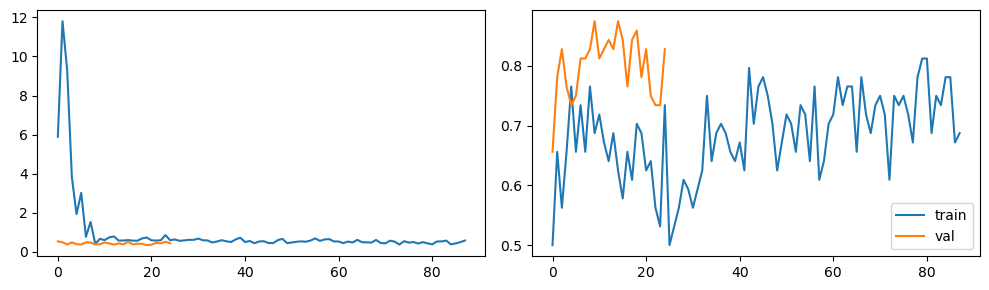

In [25]:
f, ax = plt.subplots(1, 2, figsize=(10, 3))

# plot all metrics
ax[0].plot(epoch1_metrics["train_loss"], label="train")
ax[0].plot(epoch1_metrics["val_loss"], label="val")
ax[1].plot(epoch1_metrics["train_acc"], label="train")
ax[1].plot(epoch1_metrics["val_acc"], label="val")
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# ... (Use the model for evaluation)
def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

test_acc = test(test_loader)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9688


## Model Interpretability

### Saliency Maps

In [136]:
def model_fn(mask, data, class_label=1):
    x = data.x
    x_masked = x*mask
    return model(x_masked, data.edge_index, data.batch)[0, class_label]

sample_i = np.random.randint(len(train_dataset))

input_data = train_dataset[sample_i]
print(input_data)
input_data = input_data.to(device)

mask = torch.ones_like(input_data.x).requires_grad_(True).to(device)
print(model.training)
print(mask.shape, input_data.x.shape, model(input_data.x, input_data.edge_index, input_data.batch).shape)
print(model_fn(mask, input_data, 1).shape)
mask_grad = torch.autograd.grad(model_fn(mask, input_data, 1), mask)[0]
saliency_maps = input_data.x * mask_grad

Data(x=[39, 10], edge_index=[2, 464], y=[1], motifs=[1])
False
torch.Size([39, 10]) torch.Size([39, 10]) torch.Size([1, 2])
torch.Size([])


In [101]:
saliency_maps

tensor([[ 0.0000,  0.0193, -0.0000, -0.0000,  0.0000,  0.0000, -0.0000, -0.0000,
         -0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0209, -0.0000,  0.0000,  0.0000, -0.0000, -0.0000,
          0.0000,  0.0000],
        [ 0.0011,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000, -0.0000, -0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000, -0.0000, -0.0076,
         -0.0000,  0.0000],
        [-0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000, -0.0000, -0.0000,
         -0.0002,  0.0000],
        [ 0.0000,  0.0000, -0.0000, -0.0000,  0.0009, -0.0000,  0.0000, -0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000, -0.0000, -0.0078,
         -0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0095, -0.0000,  0.0000,  0.0000,  0.0000, -0.0000,
          0.0000,  0.0000],
        [-0.0000, -0.0000, -0.0225, -0.0000,  0.0000,  0.0000, -0.0000, -0.0000,
         -0.0000,  0.0000],
        [ 0.0000,  

In [99]:
print(f'saliency: {saliency_maps.shape}\ninput_data.x: {np.argmax(input_data.x, axis=1)}\nsaliency_map: {np.argmax(np.abs(saliency_maps), axis=1)}\n'
      f'motifs: {input_data.motifs}')

saliency: torch.Size([36, 10])
input_data.x: tensor([1, 2, 0, 7, 8, 4, 7, 2, 2, 9, 1, 9, 5, 2, 8, 8, 4, 6, 5, 6, 8, 1, 9, 9,
        0, 9, 2, 8, 3, 1, 8, 1, 1, 1, 6, 1])
saliency_map: tensor([1, 2, 0, 7, 8, 4, 7, 2, 2, 9, 1, 9, 5, 2, 8, 8, 4, 6, 5, 6, 8, 1, 9, 9,
        0, 9, 2, 8, 3, 1, 8, 1, 1, 1, 6, 1])
motifs: [[18, 7, 11, 31, 16, 10]]


In [103]:
# print(np.abs(saliency_maps[input_data.motifs[0]]))
# non_motif_nodes = [node for node in range(input_data.num_nodes) if node not in input_data.motifs[0]]
# print(np.abs(saliency_maps[non_motif_nodes]))

# node importance as per saliency maps
node_attr_list = torch.argsort(torch.amax(torch.abs(saliency_maps), axis=1), descending=True)
print(node_attr_list)

tensor([31,  8,  1, 32,  0, 10, 13,  9, 16, 35, 11, 29, 22,  7, 18,  6,  3, 33,
        28, 23, 12, 25, 26, 19, 30, 15, 34, 17, 24, 20,  2,  5, 14, 27, 21,  4])


In [165]:
def visualize_graph(graph, ax):
    G = nx.Graph()

    # Create nodes for each data point in the graph
    for i in range(graph.num_nodes):
        G.add_node(i)

    # Create edges
    edges = graph.edge_index.t().tolist()
    G.add_edges_from(edges)

    # Define layout and node positions
    pos = nx.spring_layout(G, seed=42)

    # get list of max index of node feature
    graph_x = graph.x.cpu().detach().numpy()
    node_labels = {i:graph_x[i].argmax() for i in range(len(graph_x))}
    # there is only one motif in the list for this binary classification problem
    node_colors = ['lightcoral' if node in graph.motifs[0] else 'skyblue' for node in G.nodes]

    # Draw the original graph
    nx.draw_networkx(G, pos, node_color=node_colors, ax=ax)

    ax.set_title("Original Graph")

    return pos


def visualize_attributions(graph, node_attr_list, ax, pos=None):
    G = nx.Graph()
    
    # Create nodes for each data point in the graph
    for i in range(graph.num_nodes):
        G.add_node(i)
    
    # Create edges without considering attributions, since we focus on node attributions here
    for edge_index in range(graph.num_edges):
        source, target = graph.edge_index[:, edge_index].tolist()
        G.add_edge(source, target)
    
    # Define layout and node positions
    if pos is None:
        pos = nx.spring_layout(G, seed=42)
    
    # Determine node sizes based on their attribution weights
    # The largest node will have a size of `max_size`
    # and subsequent nodes will be scaled down based on their rank
    max_size = 1000
    node_sizes = [max_size * (len(node_attr_list) - rank) / len(node_attr_list) for rank in range(len(node_attr_list))]
    
    # Draw the nodes with a colormap
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_sizes, cmap=plt.get_cmap('Reds'), ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges, alpha=0.5, ax=ax)
    nx.draw_networkx_labels(G, pos, ax=ax)
    
    # Set the color bar to indicate the attribution weights
    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('Reds'), norm=plt.Normalize(vmin=min(node_sizes), vmax=max(node_sizes)))
    sm.set_array([])
    plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5, label='Node Attribution')
    
    ax.set_title("Node Attributions")
    ax.axis('off')  # Hide the axis

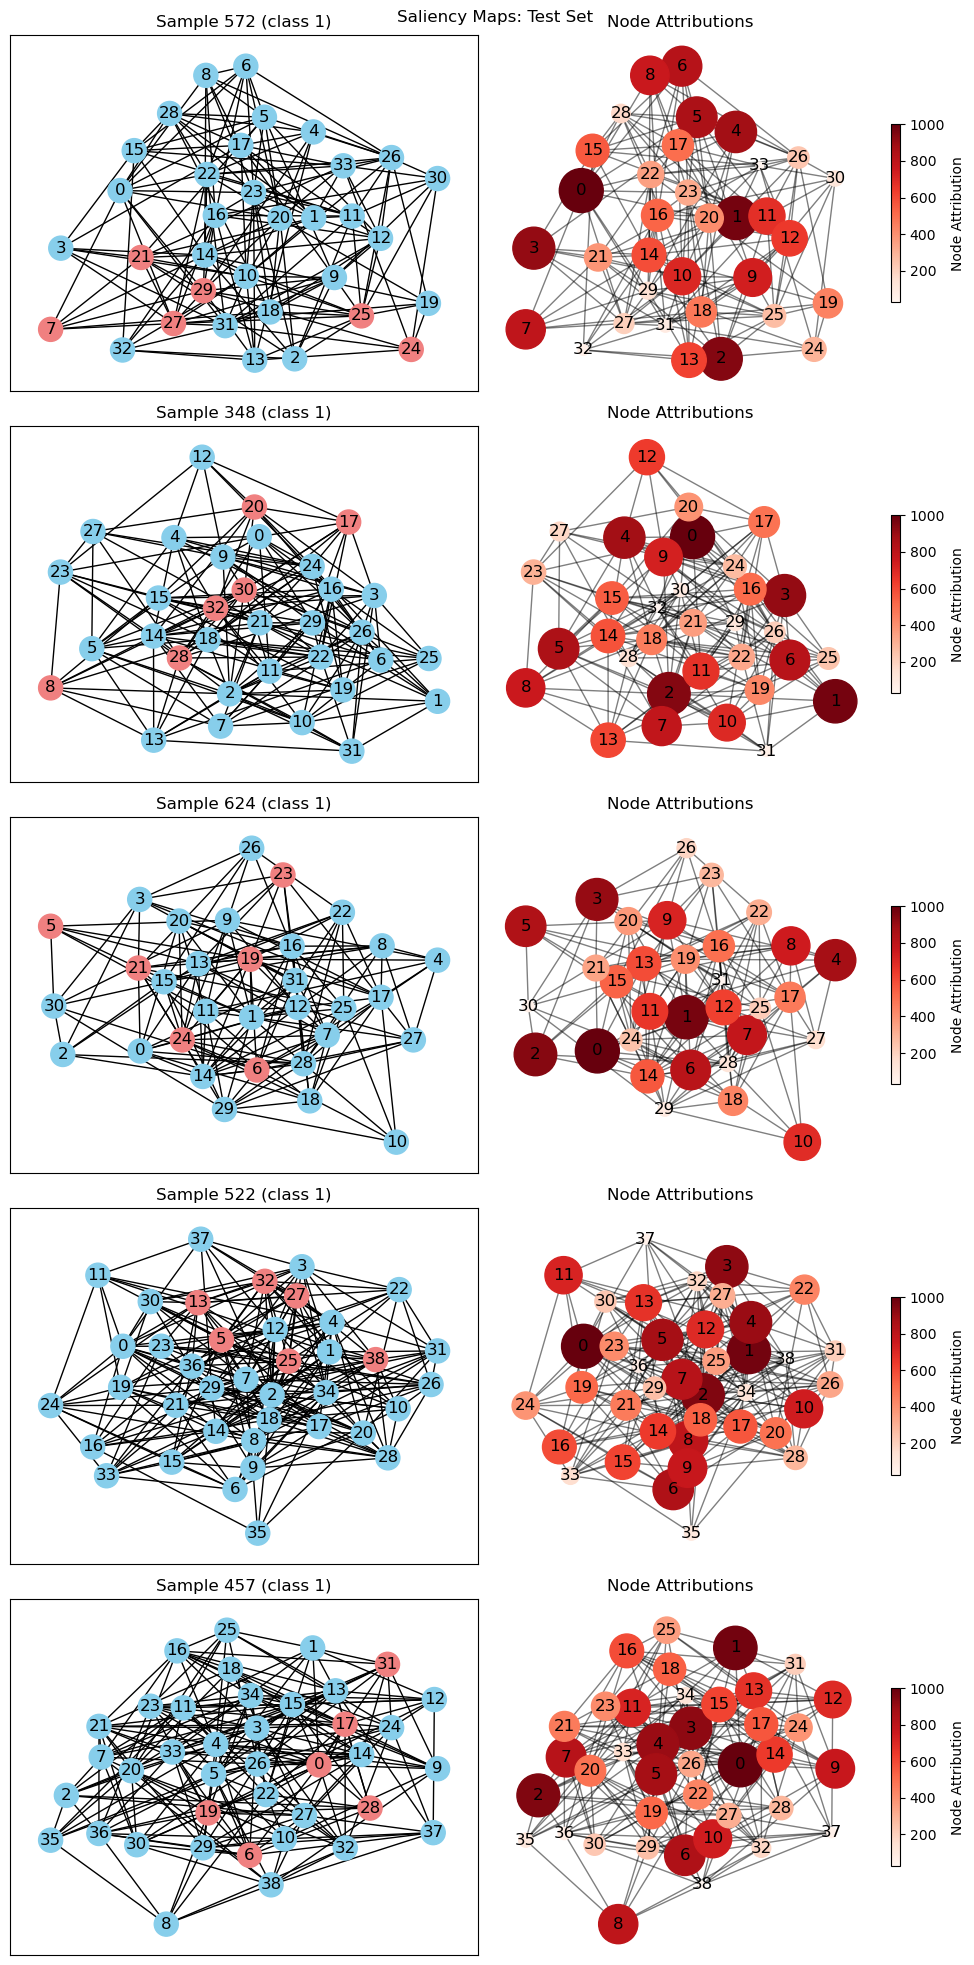

In [138]:
fig, ax = plt.subplots(5, 2, figsize=(10, 20))
plt.suptitle("Saliency Maps: Test Set")

count = 0
while count < 5:
    # pick random sample from test set
    sample_i = np.random.randint(len(test_dataset))
    input_data = test_dataset[sample_i]

    class_label = 1
    if input_data.y.item() != class_label:
        continue

    input_data = input_data.to(device)
    
    # attributions = explain(method='ig', data=input_data, target=0)
    # print('Attributions:', attributions)

    mask = torch.ones_like(input_data.x).requires_grad_(True).to(device)
    mask_grad = torch.autograd.grad(model_fn(mask, input_data, class_label), mask)[0]
    saliency_maps = input_data.x * mask_grad
    node_attr_list = torch.argsort(torch.amax(torch.abs(saliency_maps), axis=1), descending=True)

    visualize_graph(input_data, ax[count][0])
    ax[count][0].set_title(f'Sample {sample_i} (class {input_data.y.item()})')
    # Visualize attributions for the example data
    visualize_attributions(input_data, node_attr_list, ax[count][1])
    count += 1
plt.tight_layout()
plt.show()

### Integrated Gradients

In [124]:
from torch_geometric.nn import to_captum
output_idx = 0
captum_model = to_captum(model, mask_type='node', output_idx=output_idx)
batch = torch.zeros(data.x.shape[0], dtype=int)
target = int(data.y[output_idx])
ig = IntegratedGradients(captum_model)
ig_attr_node1 = ig.attribute(data.x.unsqueeze(0), target=0,
                            additional_forward_args=(data.edge_index, batch),
                            internal_batch_size=1)

# Scale attributions to [0, 1]:
ig_attr_node = ig_attr_node1.squeeze(0).abs().sum(dim=1)
ig_attr_node /= ig_attr_node.max()
ig_attr_node

ImportError: cannot import name 'to_captum' from 'torch_geometric.nn' (/Users/kumarh/anaconda3/lib/python3.11/site-packages/torch_geometric/nn/__init__.py)

In [259]:
# Generate node-level attributions for a randomly selected data point
sample_i = np.random.randint(len(test_dataset))
input_data = test_dataset[sample_i]
input_data = input_data.to(device)

out = model(input_data.x, input_data.edge_index, input_data.batch)
print(input_data.x.shape, out.shape, input_data.batch)

def model_forward(mask, data):
    x = data.x
    y_list = []
    for m in mask:
        x_masked = x*m
        y = model(x_masked, data.edge_index, data.batch)[0]
        y_list.append(y)
    return torch.stack(y_list).squeeze()

mask = torch.stack([torch.ones_like(input_data.x).requires_grad_(True).to(device)]*1)
out = model_forward(mask, input_data)
mask.shape, out.shape

ig = IntegratedGradients(model_forward)
ig_attr = ig.attribute(mask, target=0, additional_forward_args=(input_data,))[0]
node_attr_list = torch.argsort(torch.amax(torch.abs(ig_attr), axis=1), descending=True)
print(ig_attr.shape)
print(node_attr_list)


torch.Size([37, 10]) torch.Size([1, 2]) None
torch.Size([37, 10])
tensor([11,  7,  8, 23, 34, 15, 24, 10, 14, 31, 21,  5, 20, 28,  3, 33, 16, 32,
         0, 30, 17, 27,  1, 36, 12, 13,  4, 19, 25,  9, 29, 35, 26, 22, 18,  6,
         2])


In [182]:

A = np.zeros([input_data.x.shape[0], input_data.x.shape[0]])
I, J = input_data.edge_index
A[I, J] = 1
G = nx.from_numpy_array(A)

In [203]:
# G = nx.Graph()

# # Create nodes for each data point in the graph
# for i in range(input_data.num_nodes):
#     G.add_node(i)

# # Create edges
# edges = input_data.edge_index.t().tolist()
# G.add_edges_from(edges)

def shortest_path(node, motif_nodes, graph):
    paths = []
    for m in motif_nodes:
        path = nx.shortest_path(graph, source=node, target=m)
        paths.append(len(path)-1)
        # print(path)
        # print(paths[-1])
    return min(paths)

shortest_paths = {}
for node in G.nodes:
    # shortest path from node to motif
    shortest_paths[node] = shortest_path(node, input_data.motifs[0], G)

print(input_data.motifs[0])
print(list(shortest_paths.values()))

[15, 29, 34, 32, 30, 19]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


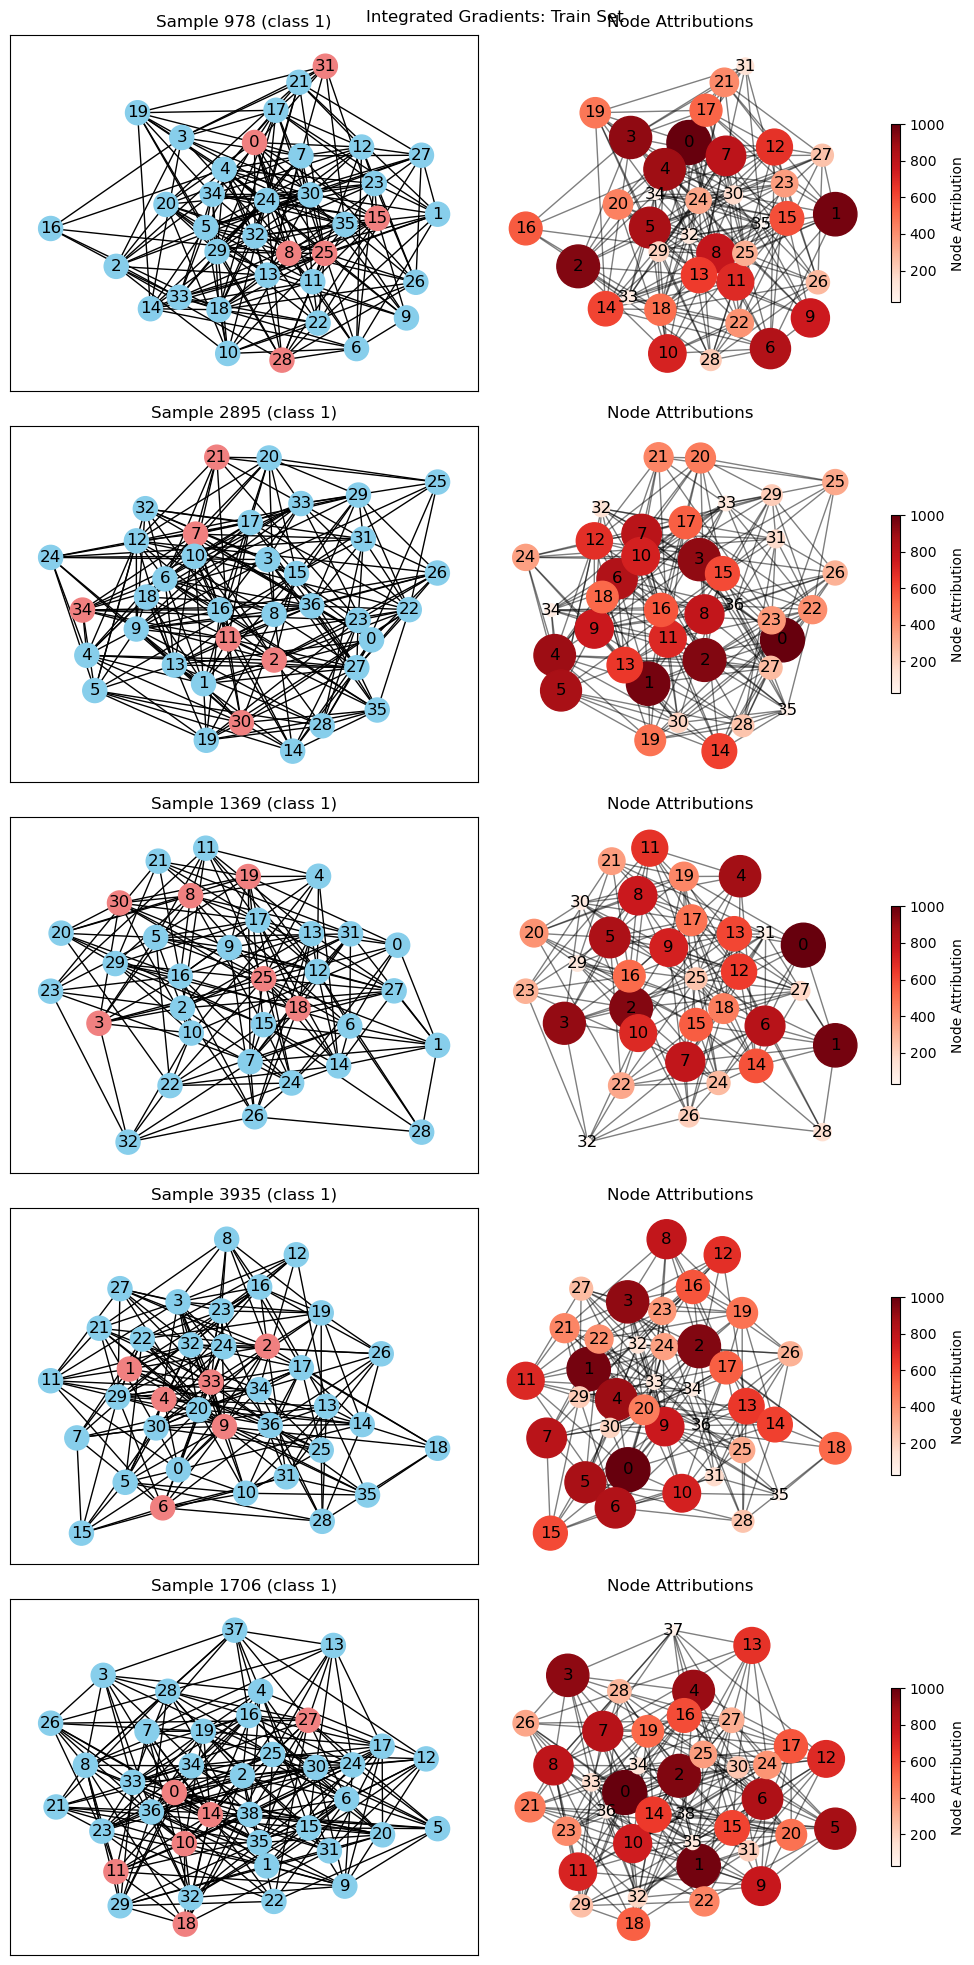

In [260]:
fig, ax = plt.subplots(5, 2, figsize=(10, 20))
plt.suptitle("Integrated Gradients: Train Set")

count = 0
while count < 5:
    # pick random sample from test set
    sample_i = np.random.randint(len(train_dataset))
    input_data = train_dataset[sample_i]

    class_label = 1
    if input_data.y.item() != class_label:
        continue

    input_data = input_data.to(device)
    
    # attributions = explain(method='ig', data=input_data, target=0)
    # print('Attributions:', attributions)
    mask = torch.stack([torch.ones_like(input_data.x).requires_grad_(True).to(device)]*1)
    out = model_forward(mask, input_data)
    mask.shape, out.shape

    ig = IntegratedGradients(model_forward)
    ig_attr = ig.attribute(mask, target=0, additional_forward_args=(input_data,), n_steps=100)[0]

    node_attr_list = torch.argsort(torch.amax(torch.abs(ig_attr), axis=1), descending=True)
    # print(node_attr_list)

    visualize_graph(input_data, ax[count][0])
    ax[count][0].set_title(f'Sample {sample_i} (class {input_data.y.item()})')
    # Visualize attributions for the example data
    visualize_attributions(input_data, node_attr_list, ax[count][1])
    count += 1
plt.tight_layout()
plt.show()

#TODO: check correlation of node importance with node degree

In [162]:
# def model_forward(node_mask, data, class_label=1):
#     """
#     Forward pass through the model with masked nodes.
#     node_mask: torch.tensor of shape (num_nodes,)
#     data: PyG data object
#     """
#     # Apply the mask to the node features. Assuming that data.x is of shape (num_nodes, num_features)
#     print('shapes', data.x.shape, node_mask.shape)
#     masked_x = data.x * node_mask[0]
#     # Forward pass through the model
#     out = model(masked_x, data.edge_index, data.batch)[0, class_label]
#     print('shapes', out.shape)
    
#     return out


def model_forward(mask, data):
    x = data.x
    y_list = []
    for m in mask:
        x_masked = x*m
        y = model(x_masked, data.edge_index, data.batch)[0]
        y_list.append(y)
    return torch.stack(y_list).squeeze()

def explain(method, data, target=0):
    """
    Explain the model's prediction using the given explanation method.
    method: 'ig' or 'saliency'
    data: PyG data object
    target: target class label
    """
    # Initialize a mask for the nodes instead of the edges
    input_mask = torch.stack([torch.ones_like(input_data.x).requires_grad_(True).to(device)]*1)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        # Calculate attributions for the nodes
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(mask, target=0, additional_forward_args=(input_data,))[0]
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    node_attributions = np.abs(mask.cpu().detach().numpy())
    if node_attributions.max() > 0:  # avoid division by zero
        node_attributions = node_attributions / node_attributions.max()
    return node_attributions


# Generate node-level attributions for a randomly selected data point
sample_i = np.random.randint(len(train_dataset))
input_data = train_dataset[sample_i]
input_data = input_data.to(device)

attributions = explain(method='ig', data=input_data, target=0)
print('Node Attributions:', attributions)


UnboundLocalError: cannot access local variable 'mask' where it is not associated with a value

/Users/kumarh/anaconda3/lib/python3.11/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 38 equal to the number of examples.
  warnings.warn(


tensor([0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006], grad_fn=<CatBackward0>) torch.Size([38])
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0006, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0006,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0006, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0006],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0006, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0006, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0

/Users/kumarh/anaconda3/lib/python3.11/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 40 equal to the number of examples.
  warnings.warn(


tensor([0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006], grad_fn=<CatBackward0>) torch.Size([40])
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0006],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0006, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0006, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0006],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0006, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0006, 0.0000,
         0.0000],
    

/Users/kumarh/anaconda3/lib/python3.11/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 36 equal to the number of examples.
  warnings.warn(


tensor([0.0317, 0.0317, 0.0317, 0.0317, 0.0317, 0.0317, 0.0317, 0.0317, 0.0317,
        0.0317, 0.0317, 0.0317, 0.0317, 0.0317, 0.0317, 0.0317, 0.0317, 0.0317,
        0.0317, 0.0317, 0.0317, 0.0317, 0.0317, 0.0317, 0.0317, 0.0317, 0.0317,
        0.0317, 0.0317, 0.0317, 0.0317, 0.0317, 0.0317, 0.0317, 0.0317, 0.0317],
       grad_fn=<CatBackward0>) torch.Size([36])
tensor([[0.0000, 0.0000, 0.0000, 0.0317, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0317, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0317, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0317, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0317, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0317, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.00

/Users/kumarh/anaconda3/lib/python3.11/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 34 equal to the number of examples.
  warnings.warn(


tensor([0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006],
       grad_fn=<CatBackward0>) torch.Size([34])
tensor([[0.0000, 0.0006, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0006, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0006, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0006, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0006, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0006, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.00

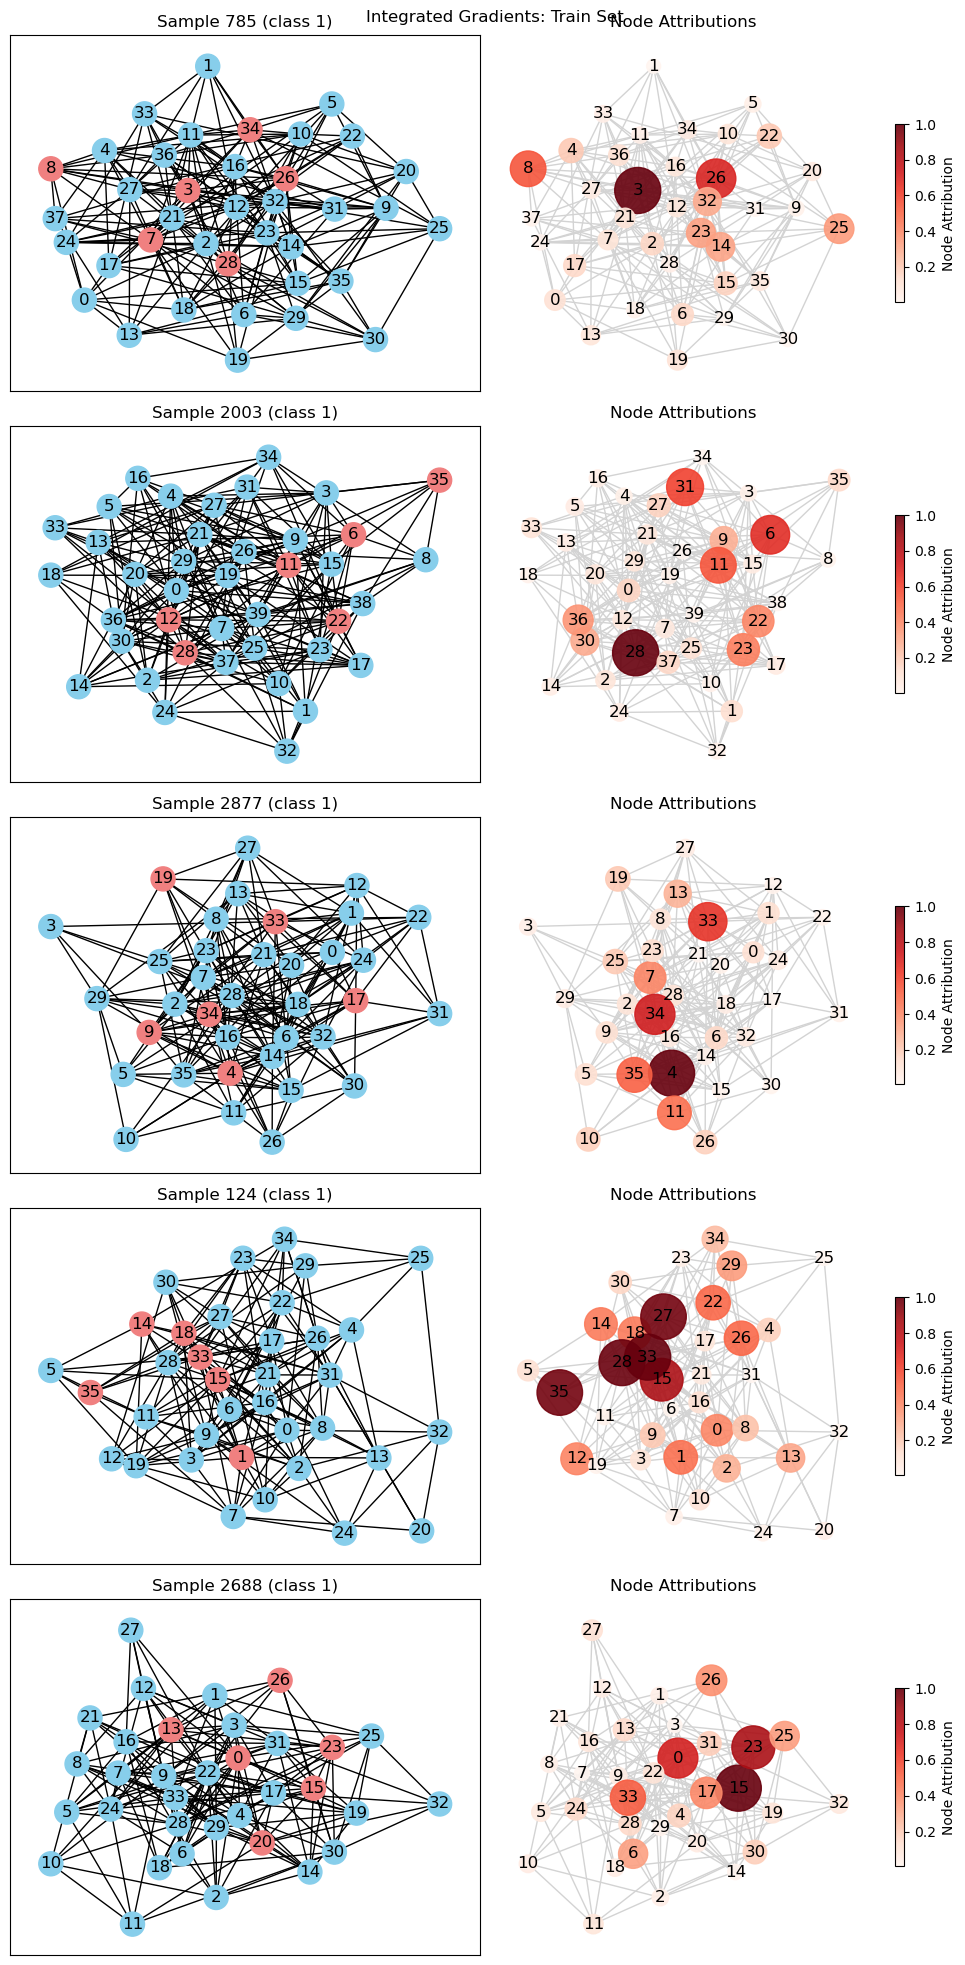

In [139]:
def visualize_attributions(graph, attributions, ax):
    G = nx.Graph()

    # Create nodes for each data point in the graph
    for i in range(graph.num_nodes):
        G.add_node(i)

    # Create edges and set edge thickness/color based on attributions
    for edge_index, attribution in enumerate(attributions):
        source, target = graph.edge_index[:, edge_index].tolist()
        G.add_edge(source, target, weight=attribution)

    # Define layout and node positions
    pos = nx.spring_layout(G, seed=42)

    # get list of max index of node feature
    graph = graph.x.cpu().detach().numpy()
    node_labels = {i:graph[i].argmax() for i in range(len(graph))}

    # Get edge thickness values
    edge_weights = [G[u][v]['weight'] for u, v in G.edges]

    # Normalize edge thickness for visualization
    edge_weights = [4 * w / max(edge_weights) for w in edge_weights]
     # Draw the graph with edge thickness based on attributions
    nx.draw_networkx(G, pos, labels=node_labels, node_color='skyblue',
            edgelist=[edge for edge in G.edges], edge_color=edge_weights, width=edge_weights,
            edge_cmap=plt.get_cmap('Blues'), ax=ax)

    ax.set_title("Edge Attributions")

    return pos

def visualize_node_attributions(graph, node_attributions, ax, pos=None):
    G = nx.Graph()

    # Create nodes for each data point in the graph
    for i in range(graph.num_nodes):
        G.add_node(i)

    # Create edges without attributions as we are focusing on node attributions
    for edge_index in range(graph.num_edges):
        source, target = graph.edge_index[:, edge_index].tolist()
        G.add_edge(source, target)

    # Define layout and node positions
    if pos is None:
        pos = nx.spring_layout(G, seed=42)

    # Normalize node attributions for visualization
    node_attributions = node_attributions / node_attributions.max()
    node_sizes = (node_attributions + 0.1) * 1000  # Scale by 1000 for visibility, 0.1 to ensure all nodes are visible

    # Draw the graph with node size and color based on node attributions
    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_attributions,
                                   cmap=plt.get_cmap('Reds'), ax=ax, alpha=0.9)
    edges = nx.draw_networkx_edges(G, pos, edgelist=G.edges, ax=ax, edge_color='lightgray')
    labels = nx.draw_networkx_labels(G, pos, ax=ax)

    # Create a color bar
    plt.colorbar(nodes, ax=ax, orientation='vertical', shrink=0.5, label='Node Attribution')

    ax.set_title("Node Attributions")
    ax.axis('off')  # Hide the axis


fig, ax = plt.subplots(5, 2, figsize=(10, 20))
plt.suptitle("Integrated Gradients: Train Set")

count = 0
while count < 5:
    # pick random sample from test set
    sample_i = np.random.randint(len(train_dataset))
    input_data = train_dataset[sample_i]

    class_label = 1
    if input_data.y.item() != class_label:
        continue

    input_data = input_data.to(device)
    
    attributions = explain(method='ig', data=input_data, target=0)
    # print('Attributions:', attributions)

    visualize_graph(input_data, ax[count][0])
    ax[count][0].set_title(f'Sample {sample_i} (class {input_data.y.item()})')
    # Visualize attributions for the example data
    visualize_node_attributions(input_data, attributions, ax[count][1])

    count += 1

plt.tight_layout()
plt.show()

### GNNExplainer

In [258]:
import torch
from torch_geometric.explain import Explainer, GNNExplainer

# Assuming `model` is your trained GNN model
# and `input_data` is a data point from `test_dataset`
# Generate node-level attributions for a randomly selected data point
sample_i = np.random.randint(len(test_dataset))
input_data = test_dataset[sample_i]
input_data = input_data.to(device)

mask = torch.stack([torch.ones_like(input_data.x).requires_grad_(True).to(device)]*1)
print(mask.shape)
# Move the model to evaluation mode
model.eval()

# def model_forward(mask, data):
#     x = data.x
#     y_list = []
#     for m in mask:
#         x_masked = x*m
#         y = model(x_masked, data.edge_index, data.batch)[0]
#         y_list.append(y)
#     return torch.stack(y_list).squeeze()

# Create an instance of GNNExplainer, passing the model
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)

# print(explainer.__dict__)
print(input_data.x.shape, input_data.edge_index.shape, input_data.y.shape, input_data.batch)


node_index = 0
explanation = explainer(x=input_data.x, 
                        edge_index=input_data.edge_index, 
                        batch=input_data.batch, 
                        target=input_data.y,
                        index=node_index)

print(f'Generated explanations in {explanation.available_explanations}')

path = 'feature_importance.png'
explanation.visualize_feature_importance(path, top_k=10)
print(f"Feature importance plot has been saved to '{path}'")

path = 'subgraph.pdf'
explanation.visualize_graph(path)
print(f"Subgraph visualization plot has been saved to '{path}'")


torch.Size([1, 31, 10])
torch.Size([31, 10]) torch.Size([2, 274]) torch.Size([1]) None
Generated explanations in ['edge_mask', 'node_mask']
Feature importance plot has been saved to 'feature_importance.png'
Subgraph visualization plot has been saved to 'subgraph.pdf'


## Edge-level attributions

In [94]:
def model_forward(edge_mask, data):
    """
    Forward pass through the model with masked edges.
    edge_mask: torch.tensor of shape (num_edges,)
    data: PyG data object
    """
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x, data.edge_index, batch, edge_mask)
    return out


def explain(method, data, target=0):
    """
    Explain the model's prediction using the given explanation method.
    method: 'ig' or 'saliency'
    data: PyG data object
    target: target class label
    """
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask

In [95]:
def visualize_graph(graph, ax):
    G = nx.Graph()

    # Create nodes for each data point in the graph
    for i in range(graph.num_nodes):
        G.add_node(i)

    # Create edges
    edges = graph.edge_index.t().tolist()
    G.add_edges_from(edges)

    # Define layout and node positions
    pos = nx.spring_layout(G, seed=42)

    # get list of max index of node feature
    graph_x = graph.x.cpu().detach().numpy()
    node_labels = {i:graph_x[i].argmax() for i in range(len(graph_x))}
    # there is only one motif in the list for this binary classification problem
    node_colors = ['lightcoral' if node in graph.motifs[0] else 'skyblue' for node in G.nodes]

    # Draw the original graph
    nx.draw_networkx(G, pos, labels=node_labels, node_color=node_colors, ax=ax)

    ax.set_title("Original Graph")

def visualize_attributions(graph, attributions, ax):
    G = nx.Graph()

    # Create nodes for each data point in the graph
    for i in range(graph.num_nodes):
        G.add_node(i)

    # Create edges and set edge thickness/color based on attributions
    for edge_index, attribution in enumerate(attributions):
        source, target = graph.edge_index[:, edge_index].tolist()
        G.add_edge(source, target, weight=attribution)

    # Define layout and node positions
    pos = nx.spring_layout(G, seed=42)

    # get list of max index of node feature
    graph = graph.x.cpu().detach().numpy()
    node_labels = {i:graph[i].argmax() for i in range(len(graph))}

    # Get edge thickness values
    edge_weights = [G[u][v]['weight'] for u, v in G.edges]

    # Normalize edge thickness for visualization
    edge_weights = [4 * w / max(edge_weights) for w in edge_weights]
     # Draw the graph with edge thickness based on attributions
    nx.draw_networkx(G, pos, labels=node_labels, node_color='skyblue',
            edgelist=[edge for edge in G.edges], edge_color=edge_weights, width=edge_weights,
            edge_cmap=plt.get_cmap('Blues'), ax=ax)

    ax.set_title("Edge Attributions")

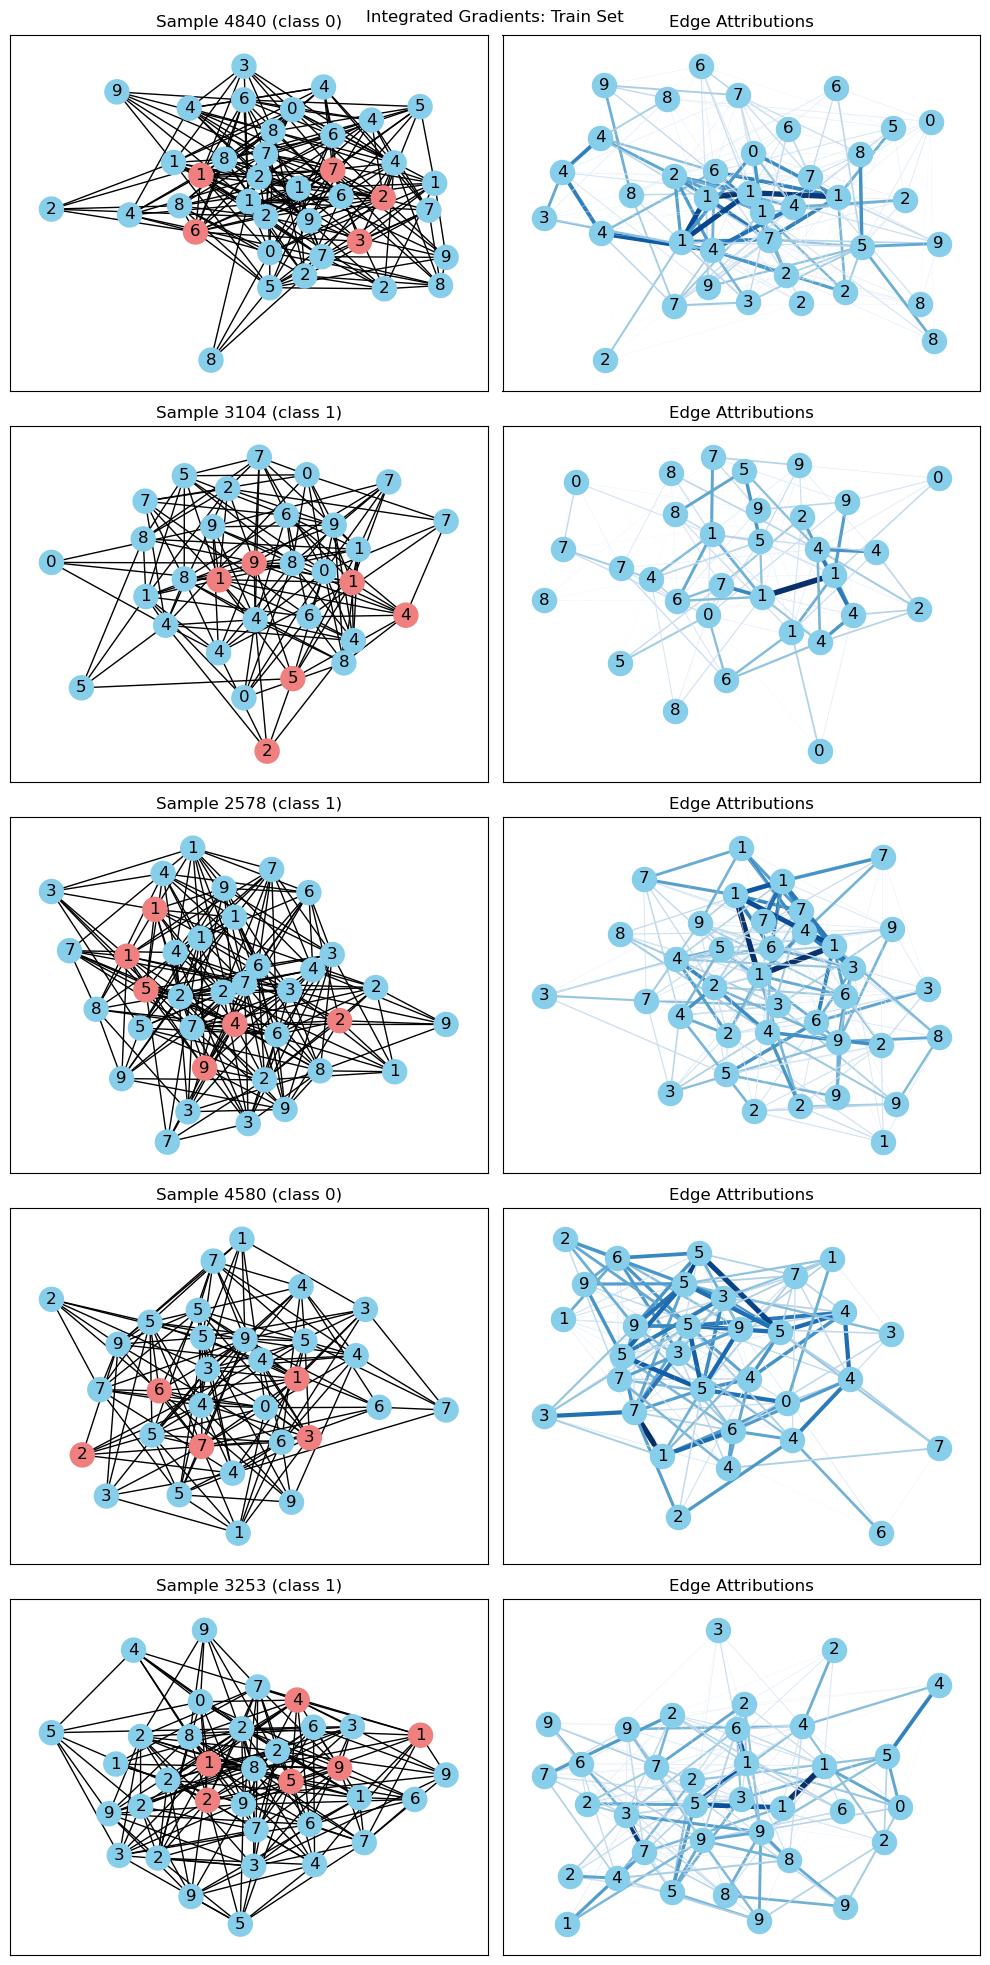

In [96]:
fig, ax = plt.subplots(5, 2, figsize=(10, 20))
plt.suptitle("Integrated Gradients: Train Set")

for i in range(5):
    # pick random sample from test set
    sample_i = np.random.randint(len(train_dataset))
    input_data = train_dataset[sample_i]
    input_data = input_data.to(device)
    
    attributions = explain(method='ig', data=input_data, target=0)
    # print('Attributions:', attributions)

    visualize_graph(input_data, ax[i][0])
    ax[i][0].set_title(f'Sample {sample_i} (class {input_data.y.item()})')
    # Visualize attributions for the example data
    visualize_attributions(input_data, attributions, ax[i][1])
plt.tight_layout()
plt.show()

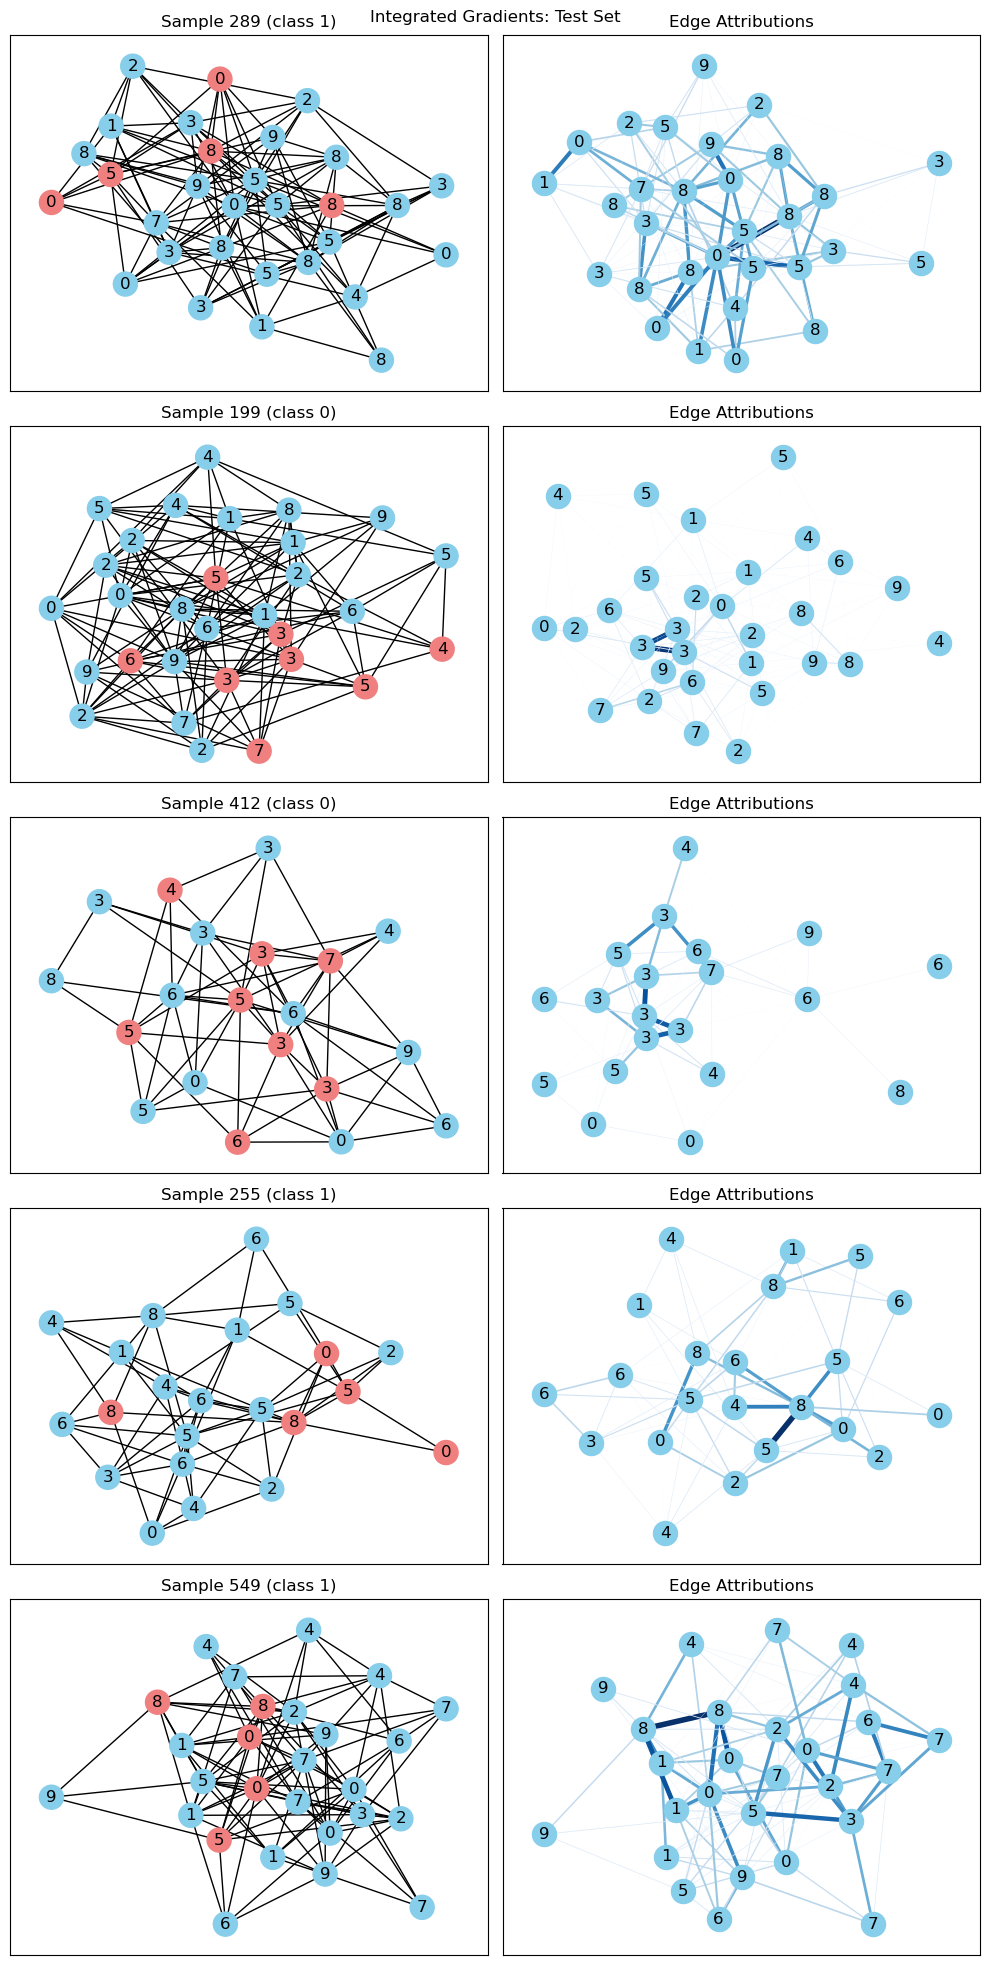

In [90]:
# plot 5 graphs from the test set 
fig, ax = plt.subplots(5, 2, figsize=(10, 20))
plt.suptitle("Integrated Gradients: Test Set")

for i in range(5):
    # pick random sample from test set
    sample_i = np.random.randint(len(test_dataset))
    input_data = test_dataset[sample_i]
    input_data = input_data.to(device)
    
    attributions = explain(method='ig', data=input_data, target=0)
    # print('Attributions:', attributions)

    visualize_graph(input_data, ax[i][0])
    ax[i][0].set_title(f'Sample {sample_i} (class {input_data.y.item()})')
    # Visualize attributions for the example data
    visualize_attributions(input_data, attributions, ax[i][1])
plt.tight_layout()
plt.show()

0


/var/folders/27/zfxsglqs1dz7r2s38wpgb8b88zxvq5/T/ipykernel_74911/2593569081.py:49: RuntimeWarning: invalid value encountered in scalar divide
  edge_weights = [4 * w / max(edge_weights) for w in edge_weights]


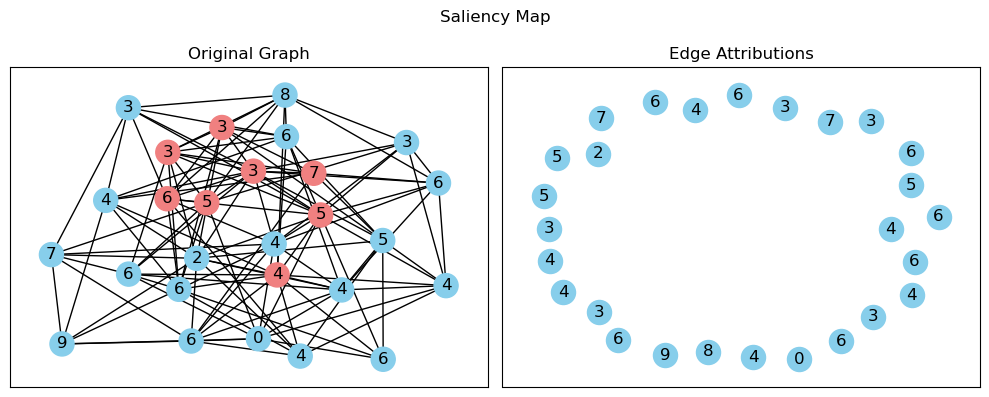

In [86]:
# Get an example input from your dataset
input_data = train_dataset[0]
input_data = input_data.to(device)
attributions = explain(method='saliency', data=input_data, target=0)
# print('Attributions:', attributions)

f, ax = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle("Saliency Map")
visualize_graph(input_data, ax[0])
# Visualize attributions for the example data
visualize_attributions(input_data, attributions, ax[1])
plt.tight_layout()
plt.show()